In [ ]:
!pip install --upgrade torch_geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
from datetime import datetime
from mlxtend.frequent_patterns import apriori, association_rules
%matplotlib inline

In [ ]:
file_path = '/content/NVDA_daily_max_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.shape

(6598, 8)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1999-01-22 00:00:00-05:00,0.040119,0.044775,0.035581,0.037612,2714688000,0.0,0.0
1,1999-01-25 00:00:00-05:00,0.040597,0.042029,0.037612,0.041552,510480000,0.0,0.0
2,1999-01-26 00:00:00-05:00,0.042029,0.042865,0.037731,0.038328,343200000,0.0,0.0
3,1999-01-27 00:00:00-05:00,0.038447,0.039403,0.036298,0.038209,244368000,0.0,0.0
4,1999-01-28 00:00:00-05:00,0.038209,0.038447,0.037850,0.038089,227520000,0.0,0.0


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
6593,2025-04-08 00:00:00-04:00,103.809998,105.849998,94.459999,96.300003,476243400,0.0,0.0
6594,2025-04-09 00:00:00-04:00,98.889999,115.099998,97.529999,114.330002,612918300,0.0,0.0
6595,2025-04-10 00:00:00-04:00,109.370003,110.860001,99.150002,107.570000,437812400,0.0,0.0
6596,2025-04-11 00:00:00-04:00,108.500000,111.550003,107.480003,110.930000,312853800,0.0,0.0
6597,2025-04-14 00:00:00-04:00,114.139999,114.290001,109.070000,110.614899,191516048,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6598 non-null   object 
 1   Open          6598 non-null   float64
 2   High          6598 non-null   float64
 3   Low           6598 non-null   float64
 4   Close         6598 non-null   float64
 5   Volume        6598 non-null   int64  
 6   Dividends     6598 non-null   float64
 7   Stock Splits  6598 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 412.5+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6598.000000,6598.000000,6598.000000,6598.000000,6.598000e+03,6598.000000,6598.000000
mean,9.423124,9.599920,9.225751,9.419892,5.973836e+08,0.000029,0.003259
std,25.299818,25.768038,24.738889,25.267199,4.300680e+08,0.000377,0.140475
min,0.032000,0.032597,0.030566,0.031283,1.968000e+07,0.000000,0.000000
25%,0.258193,0.265930,0.251258,0.258823,3.365400e+08,0.000000,0.000000
50%,0.439270,0.444745,0.432528,0.438820,4.984680e+08,0.000000,0.000000
75%,4.770583,4.816423,4.693078,4.746883,7.287660e+08,0.000000,0.000000
max,153.015919,153.115916,147.806407,149.416245,9.230856e+09,0.010000,10.000000


In [ ]:
# Creating the Figure instance
import plotly.express as px
fig = px.line(df, x="Date", y="Open")
# printing the figure instance
fig.show()

In [ ]:
fig = px.line(df, x='Date', y='High')
# Only thing I figured is - I could do this
fig.add_scatter(x=df['Date'], y=df['Low'])
# Show plot
fig.show()

In [ ]:
df['Profit'] = df['Open']-df['Close']

In [ ]:
df['Profit'].nsmallest()

,Profit
6594,-15.440002
6592,-10.180000
6424,-8.387932
6450,-7.518151
6544,-7.179348


In [ ]:
df['Profit'].nlargest()

,Profit
6565,14.848633
6531,12.888813
6567,9.449135
6393,9.017782
6426,8.897801


In [ ]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0
Profit,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['Close_scaled'] = scaler.fit_transform(df[['Close']])

In [ ]:
df.shape

(6598, 10)

In [ ]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Profit,Close_scaled
0,1999-01-22 00:00:00-05:00,0.040119,0.044775,0.035581,0.037612,2714688000,0.0,0.0,0.002507,0.000042
1,1999-01-25 00:00:00-05:00,0.040597,0.042029,0.037612,0.041552,510480000,0.0,0.0,-0.000956,0.000069
2,1999-01-26 00:00:00-05:00,0.042029,0.042865,0.037731,0.038328,343200000,0.0,0.0,0.003701,0.000047
3,1999-01-27 00:00:00-05:00,0.038447,0.039403,0.036298,0.038209,244368000,0.0,0.0,0.000238,0.000046
4,1999-01-28 00:00:00-05:00,0.038209,0.038447,0.037850,0.038089,227520000,0.0,0.0,0.000120,0.000046
...,...,...,...,...,...,...,...,...,...,...
6593,2025-04-08 00:00:00-04:00,103.809998,105.849998,94.459999,96.300003,476243400,0.0,0.0,7.509995,0.644434
6594,2025-04-09 00:00:00-04:00,98.889999,115.099998,97.529999,114.330002,612918300,0.0,0.0,-15.440002,0.765129
6595,2025-04-10 00:00:00-04:00,109.370003,110.860001,99.150002,107.570000,437812400,0.0,0.0,1.800003,0.719876
6596,2025-04-11 00:00:00-04:00,108.500000,111.550003,107.480003,110.930000,312853800,0.0,0.0,-2.430000,0.742369


In [ ]:
# Splitting Dataset into train & test split :
train_size = int(len(df)*0.7)
test_size = len(df)-train_size


train_data = df.iloc[0:train_size, :]
test_data = df.iloc[train_size:len(df), :1]

In [ ]:
train_size, test_size

(4618, 1980)

In [ ]:
# Time Series - Time Step Preprocessing :
train_size, test_size

In [ ]:
time_step = 4  # Features from t to t+3
X, y = create_dataset(df[['Close_scaled']], time_step)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6593, 4)
Shape of y: (6593,)


In [ ]:
X_train = X[:train_size - time_step -1]
y_train = y[:train_size - time_step -1]

In [ ]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [ ]:
X_test = X[train_size - time_step - 1:]
y_test = y[train_size - time_step - 1:]

In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X: (6593, 4)
Shape of y: (6593,)
Shape of X_train: (4613, 4)
Shape of y_train: (4613,)
Shape of X_test: (1980, 4)
Shape of y_test: (1980,)


Apply Stacked LSTM Model

In [ ]:
# Library import for Deep Learning models and Layers:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.5285e-05 - val_loss: 0.1002
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.6313e-06 - val_loss: 0.0801
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 8.5590e-06 - val_loss: 0.0291
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1443e-06 - val_loss: 0.0017
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4674e-07 - val_loss: 0.0019
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.5011e-07 - val_loss: 0.0021
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.6002e-08 - val_loss: 0.0020
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2812e-07 - val_loss: 0.0019
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0337e-06 - val_loss: 0.0023
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2942e-08 - val_loss: 0.0024
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.3134e-08 - val_loss: 0.0025
Epoch 12/50
73/73 ━

In [ ]:
# Let's do the prediction & check performance metrics ->
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Transforming back to original form ->
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Calculating MSE performance metrics :
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train,train_predict))

0.6161233927449805

In [ ]:
math.sqrt(mean_squared_error(y_test,test_predict))

38.57058717015819

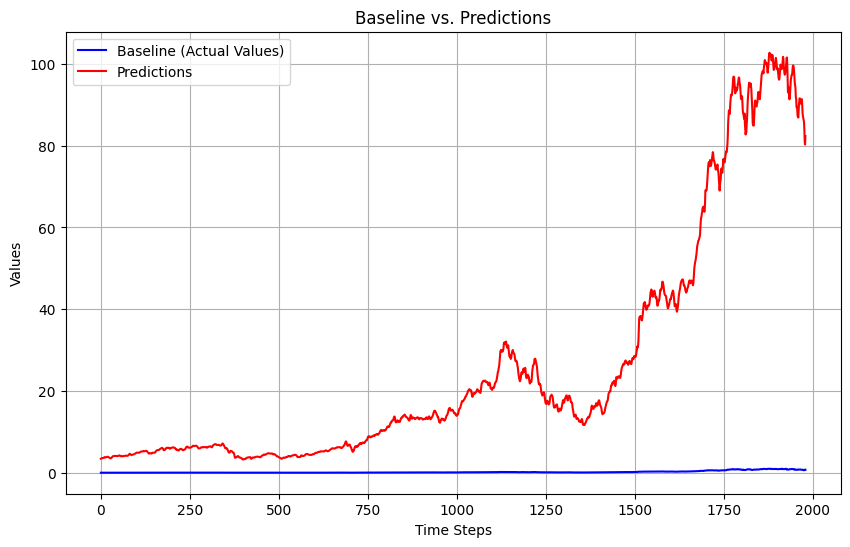

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Baseline (Actual Values)', color='blue')
plt.plot(test_predict, label='Predictions', color='red')
plt.title('Baseline vs. Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
len(test_data)

6598

In [ ]:
x_input=test_data[1507:].reshape(1,-1)
x_input.shape

(1, 10182)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[-0.003667996835625603,
 0.0008852832698901199,
 -7.702607025630859e-05,
 0.0008873332336991343,
 0.005655153103886701,
 0.0008433389614911324,
 -0.0020632513898364846,
 0.0008617538229957841,
 -0.0015286472574591037,
 0.0008755659167499935,
 -0.012685791170779087,
 0.0009625305266372863,
 0.0009170026412899934,
 0.0009609956722200166,
 0.0011462500594467129,
 0.0009630399502747073,
 -0.003438749377492112,
 0.0009850339442513182,
 -0.002904144653817109,
 0.001051538716328738,
 0.0,
 0.0010382364452122524,
 -0.010622540061341085,
 0.0011098550046787492,
 0.002598786611082593,
 0.0010939924483651458,
 -0.003133392086360709,
 0.0011067852958442103,
 0.007412117590767597,
 0.0010607463465812158,
 -0.003438749904682986,
 0.0010904139143936415,
 -0.006877499824028688,
 0.0011282700656835526,
 0.004126506058216989,
 0.0011001313672838438,
 -0.00045849444966791775,
 0.001111898484732832,
 7.611057332712612e-05,
 0.0011072946197315553,
 0.004432778646435598,
 0.0010955273027824155,
 -0.00611273

Mean Squared Error for this Dataset:- 0.59(train),38.11(test)


Apply GCN Model For This Dataset

In [ ]:
num_nodes = X.shape[0]
edge_index = torch.tensor([[i, i + 1] for i in range(num_nodes - 1)], dtype=torch.long).t().contiguous()
x = torch.from_numpy(X).type(torch.float32)

In [ ]:
# Create the Data object
data = Data(x=x, edge_index=edge_index)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()

In [ ]:
train_size = int(len(data.x) * 0.7)
train_mask = torch.zeros(len(data.x), dtype=torch.bool)
train_mask[:train_size] = True

In [ ]:
test_size = len(data.x) - train_size
test_mask = torch.zeros(len(data.x), dtype=torch.bool)
test_mask[train_size:] = True

In [ ]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

In [ ]:
print(y_train.min(), y_train.max(), y_train.mean())

0.0 0.023232244 0.00260443


In [ ]:
print(train_mask)
print(train_mask.shape)

tensor([ True,  True,  True,  ..., False, False, False])
torch.Size([6593])


In [ ]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], torch.tensor(y_train[:train_size], dtype=torch.float))

    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/50], Loss: {loss.item():.4f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning:

Using a target size (torch.Size([4613])) that is different to the input size (torch.Size([4615, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [1/50], Loss: 0.0000
Epoch [2/50], Loss: 0.7053
Epoch [3/50], Loss: 0.0236
Epoch [4/50], Loss: 0.0020
Epoch [5/50], Loss: 0.0095
Epoch [6/50], Loss: 0.0183
Epoch [7/50], Loss: 0.0254
Epoch [8/50], Loss: 0.0292
Epoch [9/50], Loss: 0.0293
Epoch [10/50], Loss: 0.0264
Epoch [11/50], Loss: 0.0214
Epoch [12/50], Loss: 0.0154
Epoch [13/50], Loss: 0.0097
Epoch [14/50], Loss: 0.0049
Epoch [15/50], Loss: 0.0017
Epoch [16/50], Loss: 0.0002
Epoch [17/50], Loss: 0.0002
Epoch [18/50], Loss: 0.0014
Epoch [19/50], Loss: 0.0031
Epoch [20/50], Loss: 0.0049
Epoch [21/50], Loss: 0.0063
Epoch [22/50], Loss: 0.0070
Epoch [23/50], Loss: 0.0069
Epoch [24/50], Loss: 0.0061
Epoch [25/50], Loss: 0.0047
Epoch [26/50], Loss: 0.0032
Epoch [27/50], Loss: 0.0018
Epoch [28/50], Loss: 0.0008
Epoch [29/50], Loss: 0.0002
Epoch [30/50], Loss: 0.0000
Epoch [31/50], Loss: 0.0003
Epoch [32/50], Loss: 0.0007
Epoch [33/50], Loss: 0.0013
Epoch [34/50], Loss: 0.0017
Epoch [35/50], Loss: 0.0019
Epoch [36/50], Loss: 0.0019
E

In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    train_mask = torch.zeros(len(data.x), dtype=torch.bool)
    train_mask[:len(y_train)] = True

    test_mask = torch.zeros(len(data.x), dtype=torch.bool)
    test_mask[len(y_train):len(y_train) + len(y_test)] = True

In [ ]:
# Calculate training MSE
train_predictions = out[train_mask].cpu().numpy()
train_mse = mean_squared_error(y_train, train_predictions)
print(f'Train MSE: {train_mse}')

Train MSE: 0.0002204398188041523


In [ ]:
# Calculate test MSE
test_predictions = out[test_mask].cpu().numpy()
test_mse = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {test_mse}')

Test MSE: 0.10150617423846311


In [ ]:
train_rmse = math.sqrt(train_mse)
test_rmse = math.sqrt(test_mse)
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 0.014847215860360901
Test RMSE: 0.3186003362183774


In [ ]:
model.eval()
with torch.no_grad():
    all_predictions = model(data.x, data.edge_index)
all_targets = np.concatenate([y_train, y_test])

# Calculate overall MSE
overall_mse = mean_squared_error(all_targets, all_predictions.cpu().numpy())

print(f'Overall MSE: {overall_mse}')

Overall MSE: 0.030638421628685925


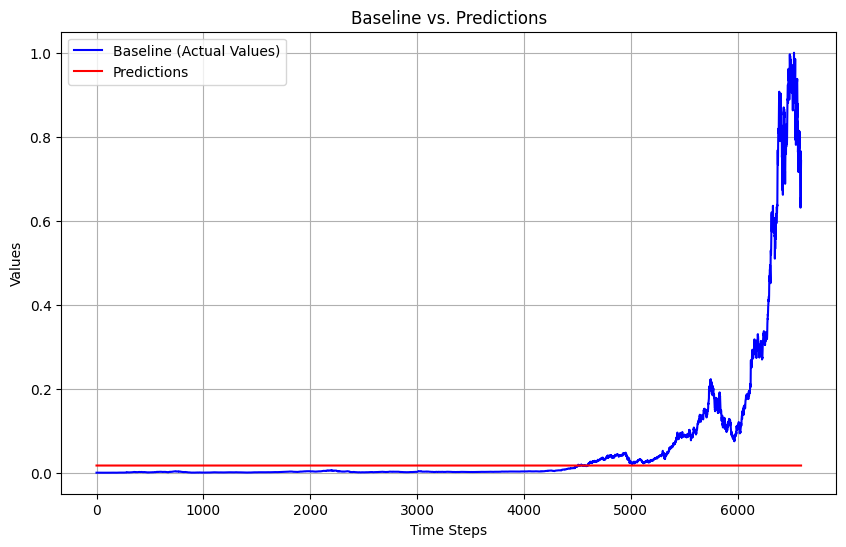

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_targets, label='Baseline (Actual Values)', color='blue')
plt.plot(all_predictions, label='Predictions', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Baseline vs. Predictions')
plt.legend()
plt.grid(True)
plt.show()

MSE For this Model:- 0.0308

Applying Hybrid LSTM-GCN Model

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

In [ ]:
sequence_length = 20
prediction_index = features.index('Close')


In [ ]:
# Create sequences
from torch.utils.data import DataLoader, Dataset
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.X = []
        self.y = []
        for i in range(len(data) - seq_len):
            self.X.append(data[i:i + seq_len])
            self.y.append(data[i + seq_len, prediction_index])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# GCN Graph (simulate a feature graph)
G = nx.Graph()
for i, feat in enumerate(features):
    G.add_node(i)
for i in range(len(features)):
    for j in range(i+1, len(features)):
        G.add_edge(i, j)

edge_index = torch.tensor(list(G.edges)).t().contiguous()


In [ ]:
class LSTM_GCN(nn.Module):
    def __init__(self, input_size, hidden_size, gcn_out, lstm_layers):
        super(LSTM_GCN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.lstm = nn.LSTM(..., dropout=0.2)
        self.gcn = GCNConv(input_size, gcn_out)
        self.fc = nn.Linear(hidden_size + gcn_out, 1)

    def forward(self, x, edge_index):
        lstm_out, _ = self.lstm(x)
        lstm_feat = lstm_out[:, -1, :]

        batch_size = x.size(0)
        gcn_outputs = []

        for i in range(batch_size):
            x_last = x[i, -1, :]
            gcn_input = x_last.unsqueeze(1).repeat(1, x.size(2))
            gcn_out = self.gcn(gcn_input, edge_index)
            gcn_out = gcn_out.mean(dim=0)
            gcn_outputs.append(gcn_out)

        gcn_outputs = torch.stack(gcn_outputs)
        combined = torch.cat((lstm_feat, gcn_outputs), dim=1)
        return self.fc(combined).squeeze()

In [ ]:
data = df_scaled.values
dataset = StockDataset(data, sequence_length)
train_size = int(0.8 * len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
model = LSTM_GCN(input_size=len(features), hidden_size=64, gcn_out=32, lstm_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch, edge_index)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.0006
Epoch 2, Loss: 0.0001
Epoch 3, Loss: 0.0001
Epoch 4, Loss: 0.0001
Epoch 5, Loss: 0.0001
Epoch 6, Loss: 0.0001
Epoch 7, Loss: 0.0001
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0001
Epoch 11, Loss: 0.0001
Epoch 12, Loss: 0.0001
Epoch 13, Loss: 0.0001
Epoch 14, Loss: 0.0001
Epoch 15, Loss: 0.0001
Epoch 16, Loss: 0.0001
Epoch 17, Loss: 0.0001
Epoch 18, Loss: 0.0001
Epoch 19, Loss: 0.0001
Epoch 20, Loss: 0.0001


In [ ]:
# Evaluation
model.eval()
preds = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch, edge_index)
        preds.extend(output.numpy())
        actuals.extend(y_batch.numpy())

In [ ]:
mse = mean_squared_error(actuals, preds)
print(f"MSE: {mse:.6f}")

MSE: 0.000044


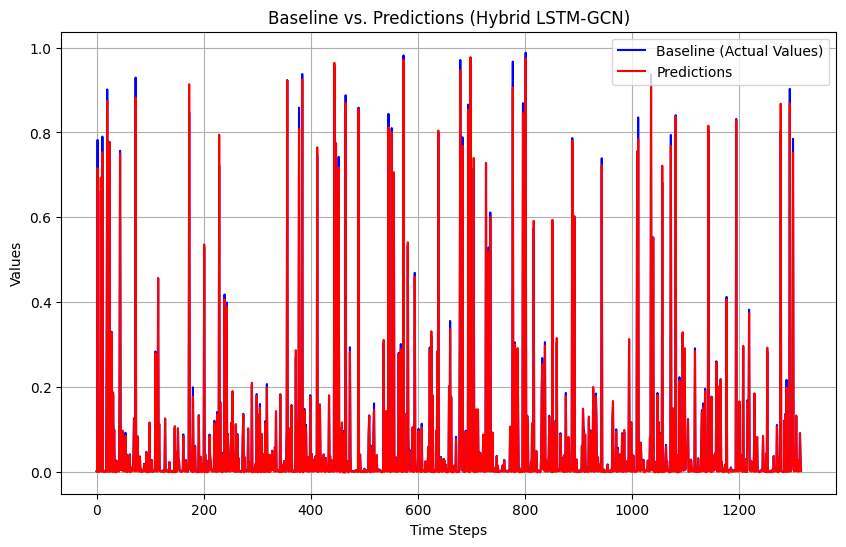

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Baseline (Actual Values)', color='blue')
plt.plot(preds, label='Predictions', color='red')
plt.title('Baseline vs. Predictions (Hybrid LSTM-GCN)')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict next 10 days
model.eval()
last_seq = torch.tensor(data[-sequence_length:], dtype=torch.float32).unsqueeze(0)
next_20 = []
full_features = []

with torch.no_grad():
    for _ in range(20):
        pred = model(last_seq, edge_index).item()
        new_row = last_seq[0, -1, :].clone()
        new_row[prediction_index] = pred
        full_features.append(new_row.numpy())
        last_seq = torch.cat([last_seq[:, 1:, :], new_row.unsqueeze(0).unsqueeze(0)], dim=1)
        next_10.append(pred)


full_features_np = np.array(full_features)
predicted_prices = scaler.inverse_transform(full_features_np)
predicted_close_prices = predicted_prices[:, prediction_index]

print("\nPredicted Closing Prices for Next 10 Days:")
for i, price in enumerate(predicted_close_prices, 1):
    print(f"Day {i}: ${price:.4f}")



Predicted Closing Prices for Next 10 Days:
Day 1: $112.1485
Day 2: $112.3143
Day 3: $112.3509
Day 4: $112.3636
Day 5: $112.3679
Day 6: $112.3689
Day 7: $112.3689
Day 8: $112.3686
Day 9: $112.3684
Day 10: $112.3682
Day 11: $112.3680
Day 12: $112.3680
Day 13: $112.3679
Day 14: $112.3679
Day 15: $112.3678
Day 16: $112.3678
Day 17: $112.3678
Day 18: $112.3678
Day 19: $112.3677
Day 20: $112.3677


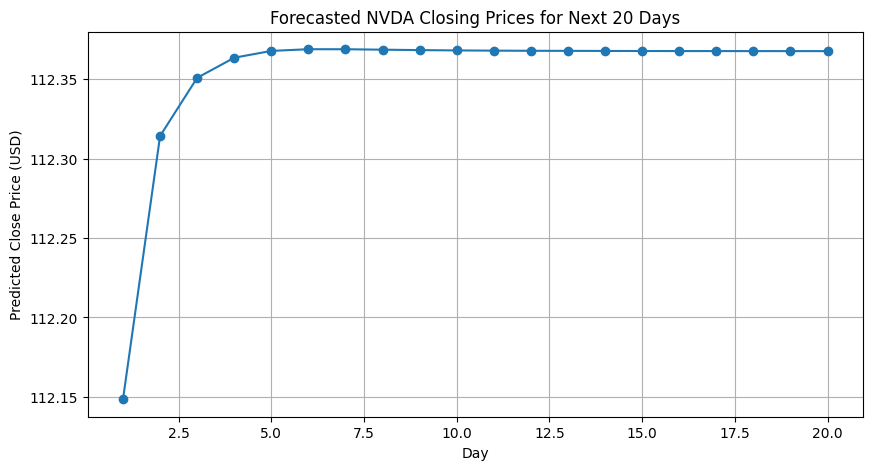

In [ ]:
# Plot 20-day forecast
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), predicted_close_prices, marker='o')
plt.title("Forecasted NVDA Closing Prices for Next 20 Days")
plt.xlabel("Day")
plt.ylabel("Predicted Close Price (USD)")
plt.grid(True)
plt.show()

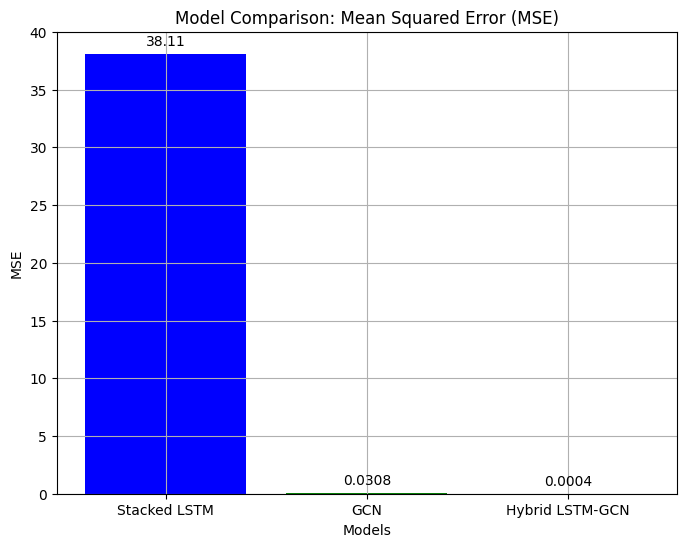

In [ ]:
models = ['Stacked LSTM', 'GCN', 'Hybrid LSTM-GCN']
mse_values = [38.11, 0.0308, 0.00039]
plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.title('Model Comparison: Mean Squared Error (MSE)')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.grid(True)

for i, v in enumerate(mse_values):
    plt.text(i, v + 0.5, str(round(v, 4)), ha='center', va='bottom')

plt.show()